# Modelo para Film Junky Union

## Índice <a id='back'></a>
* [Introducción](#intro)
* [Etapa 1. Descripción y preprocesamiento de los datos](#data_review)
    * [1. 1. Información general de los datos](#data_review_data)
    * [1. 2. Conclusiones](#data_review_conclusions)
* [Etapa 2. Análisis de datos](#data_analysis)
* [Etapa 3. Entrenamiento de modelos](#data_model)
    * [3. 1. Modelo 0 - Constante](#data_model_constant)
    * [3. 2. Modelo 1 - NLTK, TF-IDF y LR](#data_model_nltk)
    * [3. 3. Modelo 2 - spaCy, TF-IDF y LR](#data_model_spacy-lr)
    * [3. 4. Modelo 3 - spaCy, TF-IDF y LGBMClassifier](#data_model_spacy-lgbm)
    * [3. 5. Conclusiones](#data_model_conclusions)
* [Etapa 4. Ejemplo utilizando los modelos](#data_example)
* [Etapa 5. Conclusión general](#data_conclusion)

## Introducción <a id='intro'></a>

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. El objetivo de este proyecto es entrenar un modelo para detectar las críticas negativas de forma automática. Se cuenta con un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad, con esto se construirá un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

Los datos se almacenan en el archivo `/datasets/imdb_reviews.tsv`. Como se desconoce la calidad de los datos, el proyecto consistirá en cinco etapas:

1. Descripción y preprocesamiento de los datos.
2. Análisis de datos.
3. Entrenamiento de modelos.
4. Ejemplo utilizando los modelos.
5. Conclusión general.

[Volver a Contenidos](#back)

## Etapa 1. Descripción y preprocesamiento de los datos <a id='data_review'></a>

Se importan las librerías necesarias.

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

import spacy
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

#import torch
#import transformers

In [2]:
# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [4]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

Se leerá el archivo y se guardará en la variable `data`. 

In [5]:
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

### 1. 1. Información general de los datos <a id='data_review_data'></a>

Se imprimirá la información general de `data` y las primeras 10 filas de éste.

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.head(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


El dataframe contiene 47,331 filas y 17 columnas, de las cuales son de interés para este proyecto las siguientes:

1. `review` - el texto de la reseña.
2. `pos` - clasificación de la reseña: 0 para negativo, 1 para positivo (es el objetivo del modelo).
3. `ds_part` - clasifica filas para el conjunto de entrenamiento y para el conjunto de prueba.

Las columnas `average_rating` y `votes` son las únicas con valores ausentes, cada una con 2. Por ser un porcentaje mínimo, se decide eliminar dichas filas.

In [8]:
df_reviews = df_reviews.dropna().reset_index(drop=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47329 entries, 0 to 47328
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

Ya no se tienen valores ausentes. Se investigará si exiten filas duplicadas.

In [9]:
df_reviews.duplicated().sum()

0

No existen filas duplicadas, de esta manera, el dataframe está listo para el análisis que se realizará en la siguiente etapa.

[Volver a Contenidos](#back)

### 1. 2. Conclusiones <a id='data_review_conclusions'></a>

En esta etapa se abrió el archivo y se guardó en un dataset, el cual contiene información sobre las películas así como sus reseñas y la clasificación de éstas.

Se eliminaron las filas con valores ausentes (2 filas en total) y el dataframe no presentó filas duplicadas.

[Volver a Contenidos](#back)

## Etapa 2. Análisis de datos <a id='data_analysis'></a>

En esta etapa se analizarán los datos. Primero se analizará la cantidad de películas y reseñas a lo largo de los años.

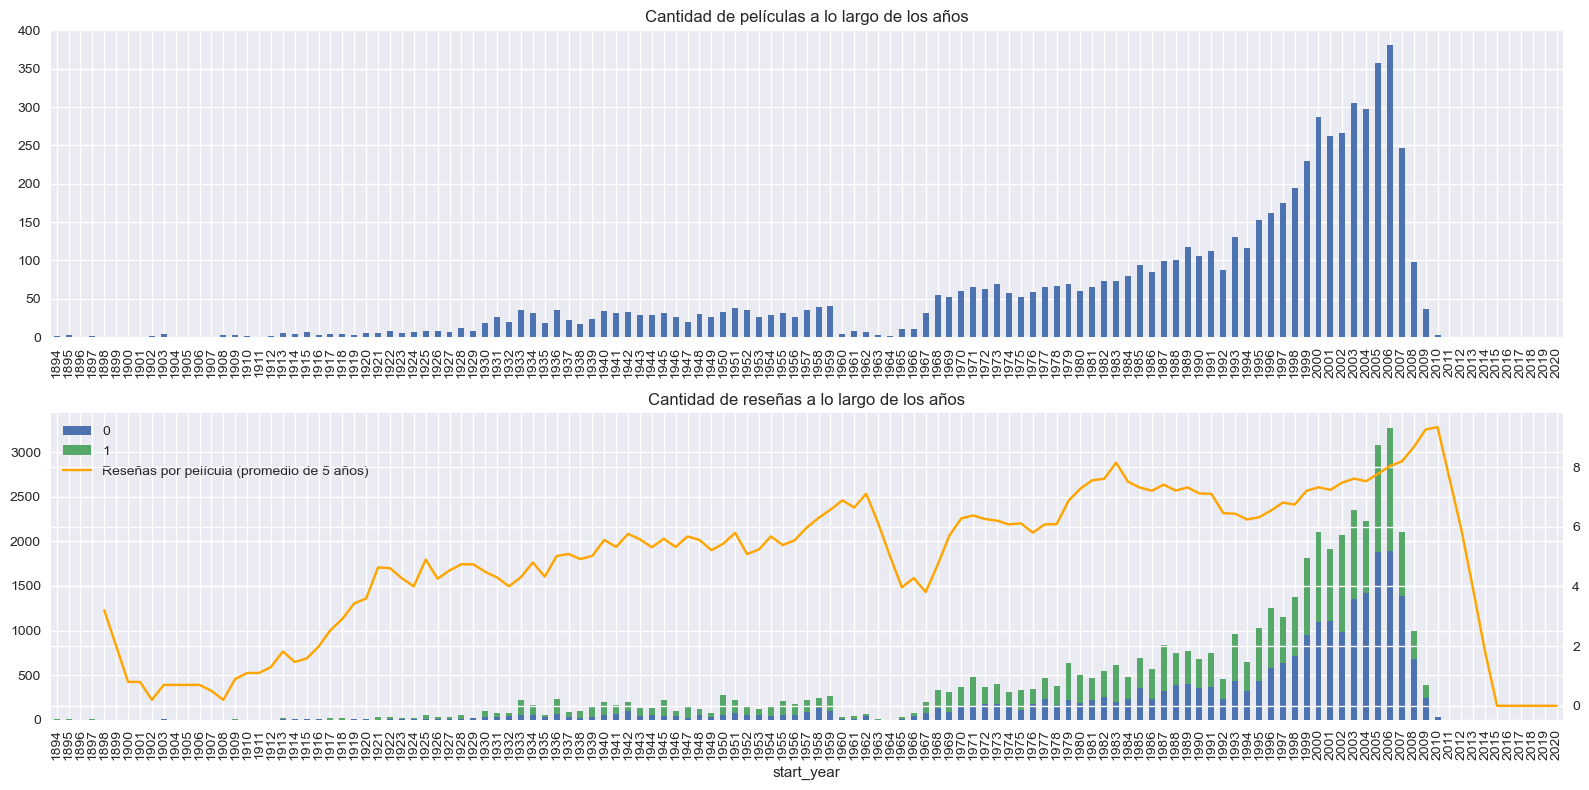

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)

ax.set_title('Cantidad de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='Reseñas por película (promedio de 5 años)', ax=axt)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

ax.set_title('Cantidad de reseñas a lo largo de los años')

fig.tight_layout()

Hasta el año 2006 se observa crecimiento tanto en la cantidad de películas como en la de reseñas, sin embargo, después de ese año estas cantidades comienzan a decrecer hasta casi desvanecerse por completo.

A continuación se analizará la distribución de la cantidad de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto).

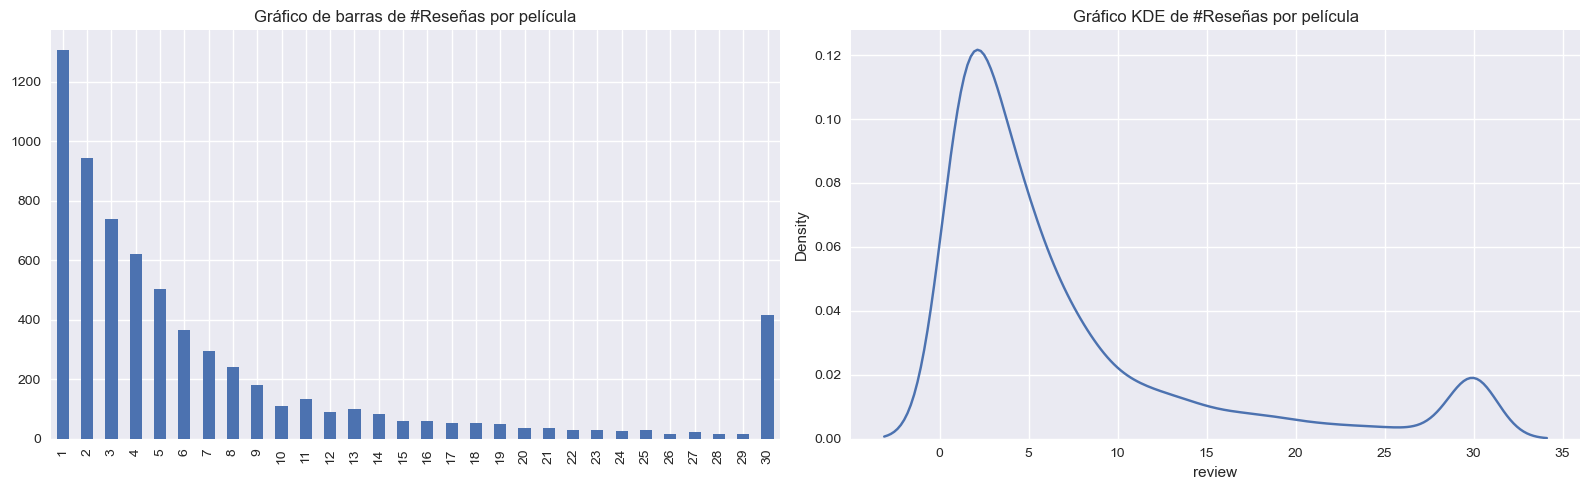

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Existen más películas con una sóla reseña y esta cantida decrece conforme aumenta la cantidad de reseñas hasta 29. Se tienen aproximadamente 420 películas con 30 reseñas.

El objetivo para el modelo es la columna `pos`, por lo que se analizará si existe desequilibrio de clases.

In [19]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

Se observa que ambas clases tienen un frecuencia similar, es decir, están balanceadas.

A continuación se analizará la distribución de las puntuaciones, tanto para el conjunto de entrenamiento como para el de prueba.

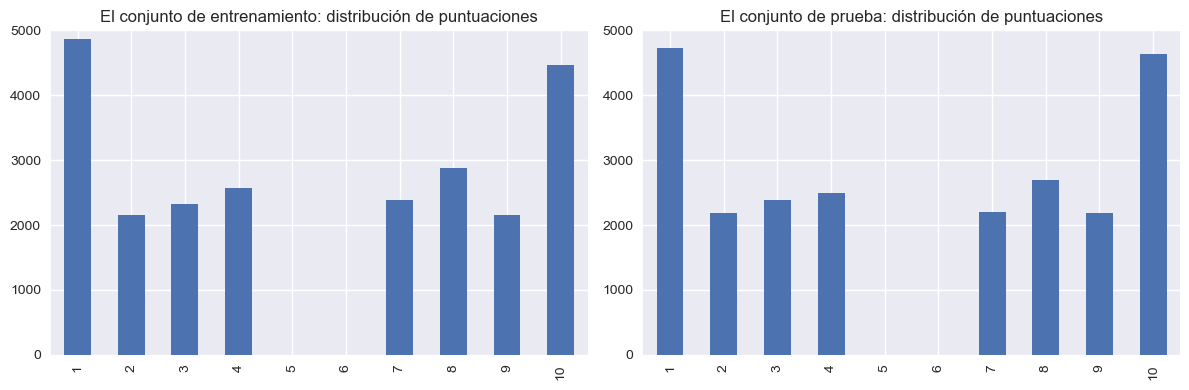

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Las distribuciones en ambos conjuntos son similares. La puntuación 1 es la que tiene la mayor cantidad de películas, seguida por la puntuación 10. Las puntuaciones 2, 3, 4, 7, 8 y 9 no tienen una gran diferencia en la cantidad de películas mientras que la cantidad de películas con puntuaciones 5 y 6 es muy baja.

Se analizará la distribución de reseñas positivas y negativas a lo largo de los años también para ambos conjuntos de datos.

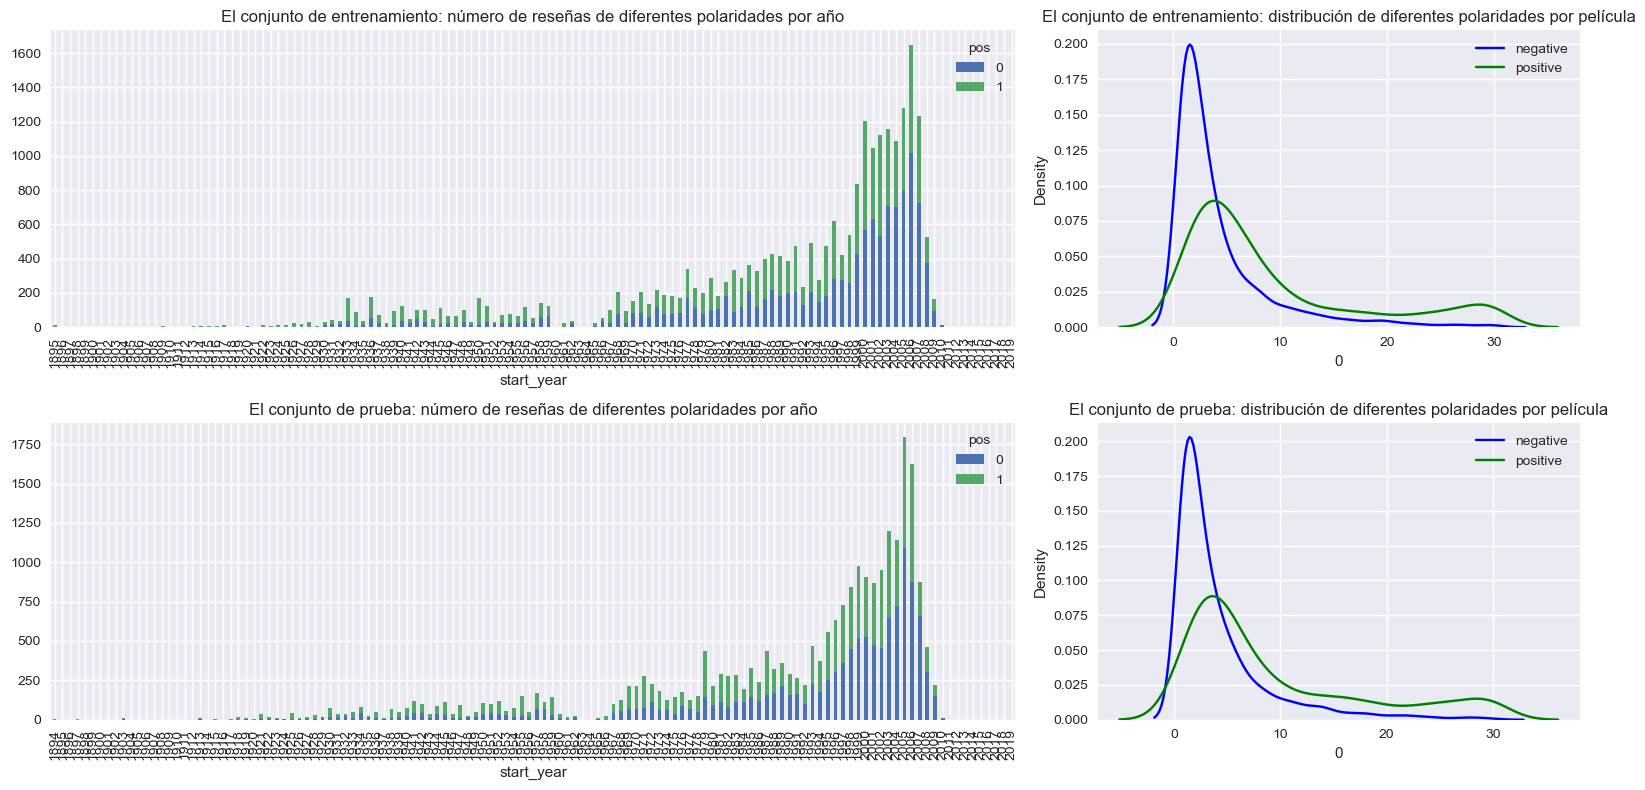

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Las distribuciones son similares para ambos conjuntos. Se observa que a lo largo de los años se tienen más reseñas negativas que positivas.

[Volver a Contenidos](#back)

## Etapa 3. Entrenamiento de modelos <a id='data_model'></a>

En esta etapa se entrenarán modelos para predecir si una reseña es positiva o negativa. Primero se definirá una rutina de evaluación que se pueda usar para todos los modelos de este proyecto.

In [22]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

**Normalización**

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [23]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

**Conjuntos de entrenamiento y prueba**

Todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [24]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


### 3. 1 Modelo 0 - Constante <a id='data_model_constant'></a>

Se entrenará un modelo constante, cuya rutina de evaluación se utilizará como prueba de cordura. Lo primero es crear una lista con palabras vacías (artículos, preposiciones, etc).

In [25]:
stop = set(stopwords.words('english'))

A continuación se establecerán las características de los conjuntos de entrenamiento y prueba para entrenar el modelo. Para ello se creará una función para la lematización de las reseñas.

In [26]:
#Características de los conjuntos de entrenamiento y prueba

train = []
test = []

lemmatizer = WordNetLemmatizer()

def features0(column, alist):
    for text in column:
        tokens = word_tokenize(text)
        bow = [token for token in tokens if not token in stop]
        lemmas = [lemmatizer.lemmatize(token) for token in bow]
        lem_join = " ".join(lemmas)
        alist.append(lem_join)
    return alist

feat_train0 = features0(df_reviews_train['review_norm'], train)
feat_test0 = features0(df_reviews_test['review_norm'], test)

print(len(feat_train0))
print(len(feat_test0))

23796
23533


Con estas características se procede al entrenamiento del modelo.

In [27]:
dummy_clf = DummyClassifier()
dummy_clf.fit(feat_train0, train_target)

DummyClassifier()

Finalmente, se procede con la rutina de evaluación.

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


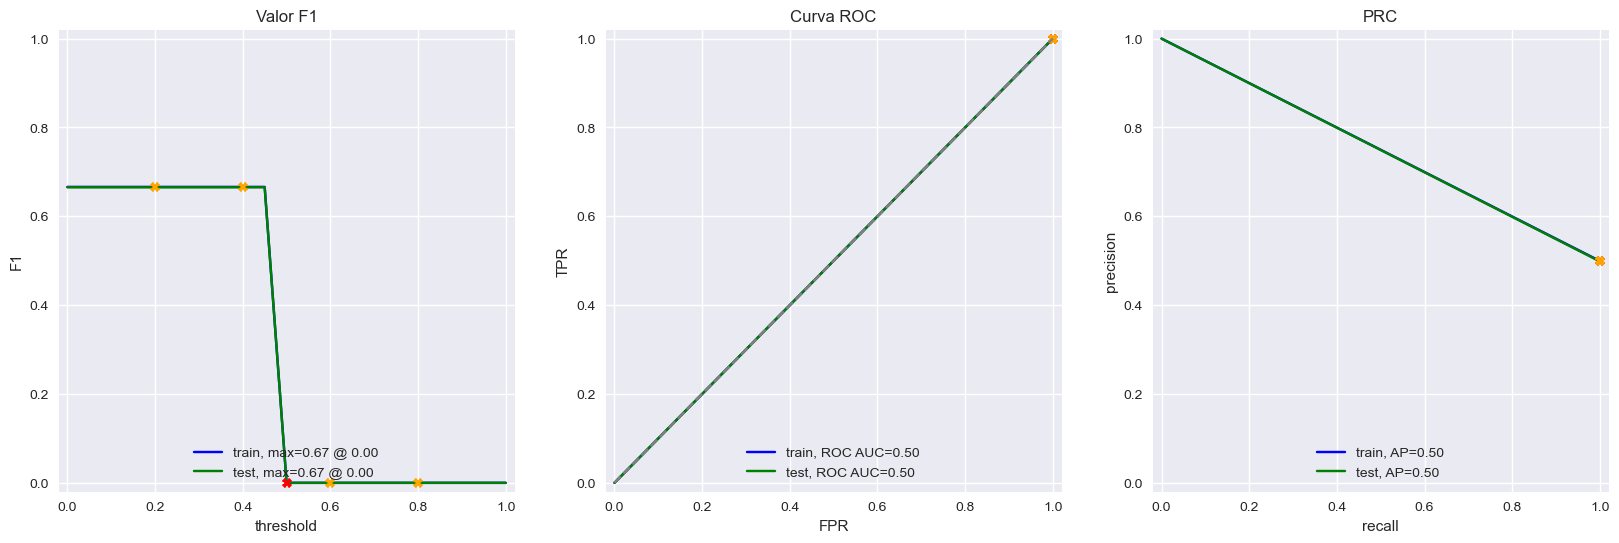

In [28]:
evaluate_model(dummy_clf, feat_train0, train_target, feat_test0, test_target)

El valor F1 es 0 y el objetivo es obtener al menos 0.85.

[Volver a Contenidos](#back)

### 3. 2. Modelo 1 - NLTK, TF-IDF y LR <a id='data_model_nltk'></a>

En esta sección se entrenará el modelo basado en regresión logística, utilizando para la lematización y tokenización la librería NLTK y determinando la importancia de una palabra por el valor TF-IDF.

In [29]:
# Características de los conjuntos de entrenamiento y prueba

train = []
test = []

lemmatizer = WordNetLemmatizer()

# Función para tokenización y lematización
def features1(column, alist):
    for text in column:
        tokens = word_tokenize(text)
        lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        lem_join = " ".join(lemmas)
        alist.append(lem_join)
    return alist

feat_train1 = features1(df_reviews_train['review_norm'], train)
feat_test1 = features1(df_reviews_test['review_norm'], test)

print(len(feat_train1))
print(len(feat_test1))

23796
23533


In [30]:
# Bolsa de palabras vacías
count_tf_idf2=TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,1))

# Características sin palabras vacías
feat_train1 = count_tf_idf2.fit_transform(feat_train1)
feat_test1 = count_tf_idf2.transform(feat_test1)

Se entrena el modelo basado en la regresión logística.

In [31]:
lr = LogisticRegression(C=0.5)
lr.fit(feat_train1, train_target)

LogisticRegression(C=0.5)

Finalmente, se procede con la rutina de evaluación.

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


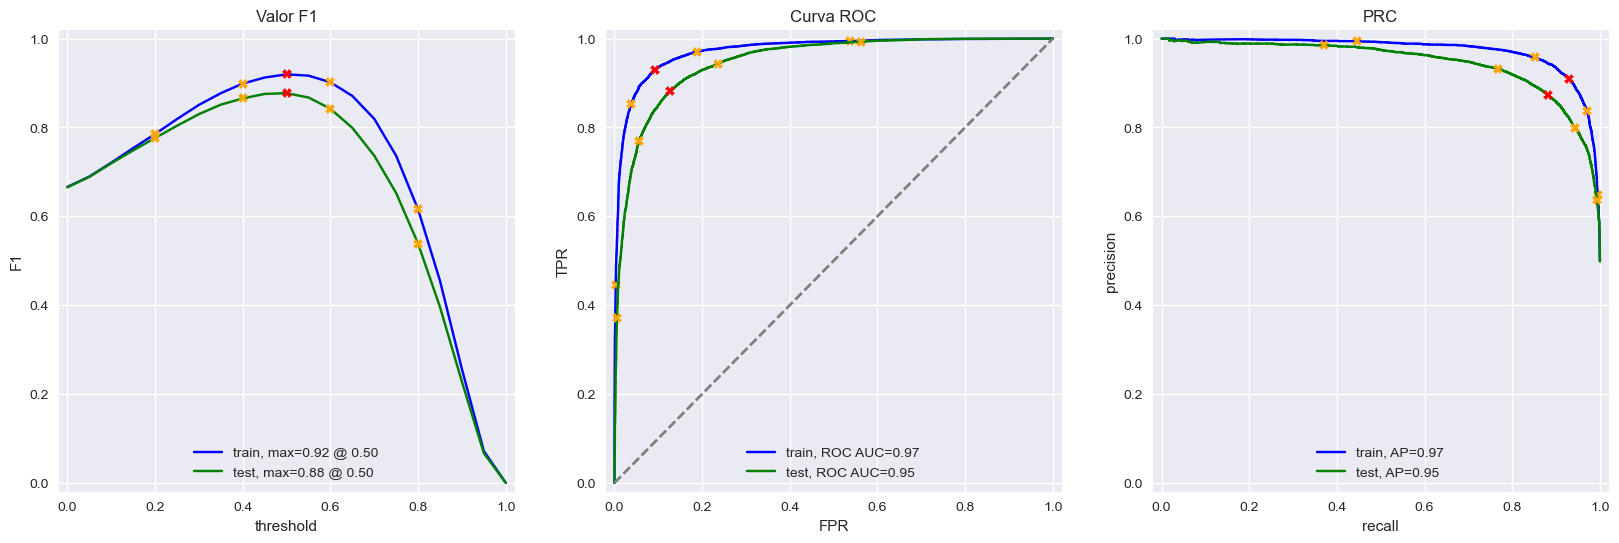

In [32]:
evaluate_model(lr, feat_train1, train_target, feat_test1, test_target)

El valor F1 en el conjunto de entrenamiento es 0.92 mientras que en el conjunto de prueba es 0.88. Este último supera el objetivo.

[Volver a Contenidos](#back)

### 3. 3. Modelo 2 - spaCy, TF-IDF y LR <a id='data_model_spacy-lr'></a>

En esta sección se entrenará el modelo basado en regresión logística, utilizando para la lematización y tokenización la librería spaCy y determinando la importancia de una palabra por el valor TF-IDF.

In [33]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [34]:
# Función para lematizar
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(lemmas)

In [35]:
# Características
train = []
test = []

def features2(column, alist):
    for text in column:
        review = lemmatize(text)
        alist.append(review)
    return alist

feat_train2 = features2(df_reviews_train['review_norm'], train)
feat_test2 = features2(df_reviews_test['review_norm'], test)

print(len(feat_train2))
print(len(feat_test2))

23796
23533


In [36]:
# Vectorizando
count_tf_idf=TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,1))
feat_train2 = count_tf_idf.fit_transform(feat_train2)
feat_test2 = count_tf_idf.transform(feat_test2)

Se entrena el modelo basado en la regresión logística.

In [37]:
lr2 = LogisticRegression(C=0.5)
lr2.fit(feat_train2, train_target)

LogisticRegression(C=0.5)

Finalmente, se procede con la rutina de evaluación.

          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


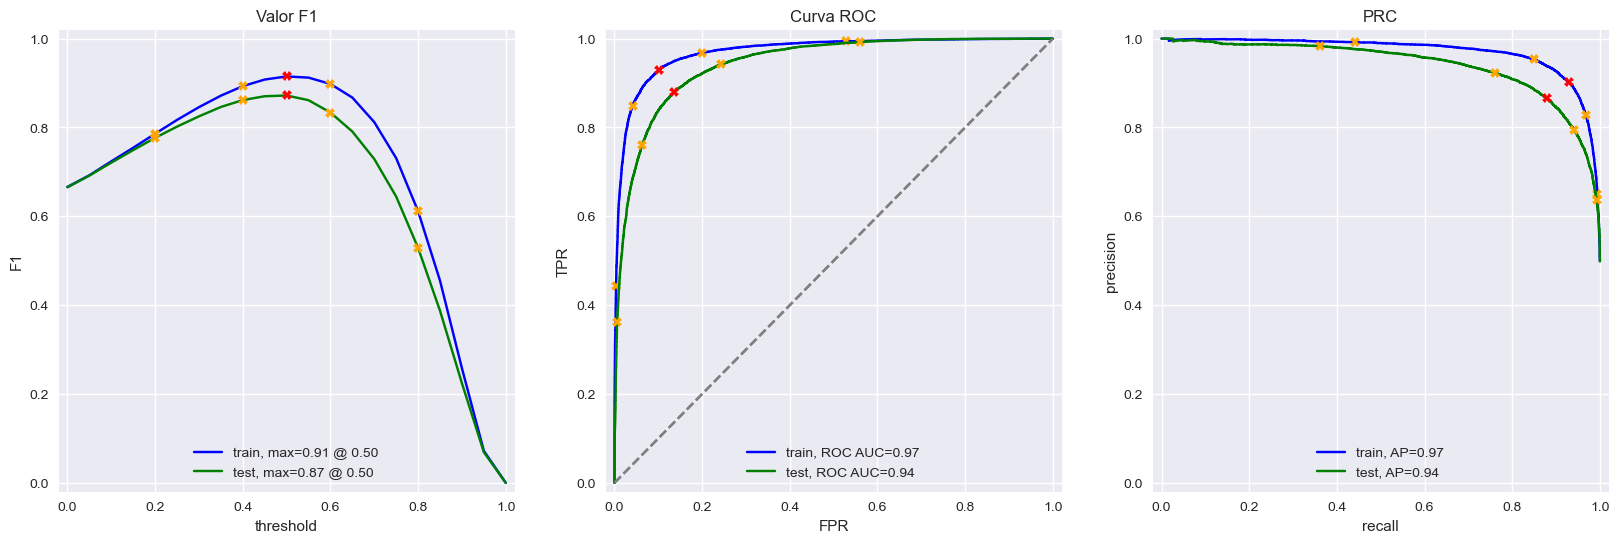

In [38]:
evaluate_model(lr2, feat_train2, train_target, feat_test2, test_target)

El valor F1 en el conjunto de entrenamiento es 0.91 mientras que en el conjunto de prueba es 0.87. Este último supera el objetivo pero es ligeramente menor que el obtenido utilizando la librería NLTK.

[Volver a Contenidos](#back)

### 3. 4. Modelo 3 - spaCy, TF-IDF y LGBMClassifier <a id='data_model_spacy-lgbm'></a>

En esta sección se entrenará el modelo con LGBMClassifier. Se utilizarán las características del modelo anterior, pues fueron lematizadas y tokenizadas utilizando spaCy y TF-IDF.

Se entrenará el modelo variando parámetros para elegir los mejores.

In [39]:
model=LGBMClassifier()

parameters={'num_leaves':[40, 50, 60],
            'learning_rate':[0.5, 0.1, 0.7],
            'n_estimators':[20, 30, 40],
            'objective':['binary'],
            'random_state':[12345]}

grid=GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(feat_train2, train_target)
best_param=grid.best_params_

print('Mejor puntuación:', grid.best_score_)
print('Mejores parámetros:', best_param)

Mejor puntuación: 0.840395031921748
Mejores parámetros: {'learning_rate': 0.5, 'n_estimators': 30, 'num_leaves': 50, 'objective': 'binary', 'random_state': 12345}


Se reentranará el modelo con los mejores parámetros.

In [40]:
lgbm = LGBMClassifier(num_leaves=best_param['num_leaves'],
                      learning_rate=best_param['learning_rate'],
                      n_estimators=best_param['n_estimators'],
                      objective='binary',
                      random_state=12345)

lgbm.fit(feat_train2, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=30, num_leaves=50,
               objective='binary', random_state=12345)

Finalmente, se procede con la rutina de evaluación.

          train  test
Accuracy   0.96  0.85
F1         0.96  0.85
APS        0.99  0.92
ROC AUC    0.99  0.93


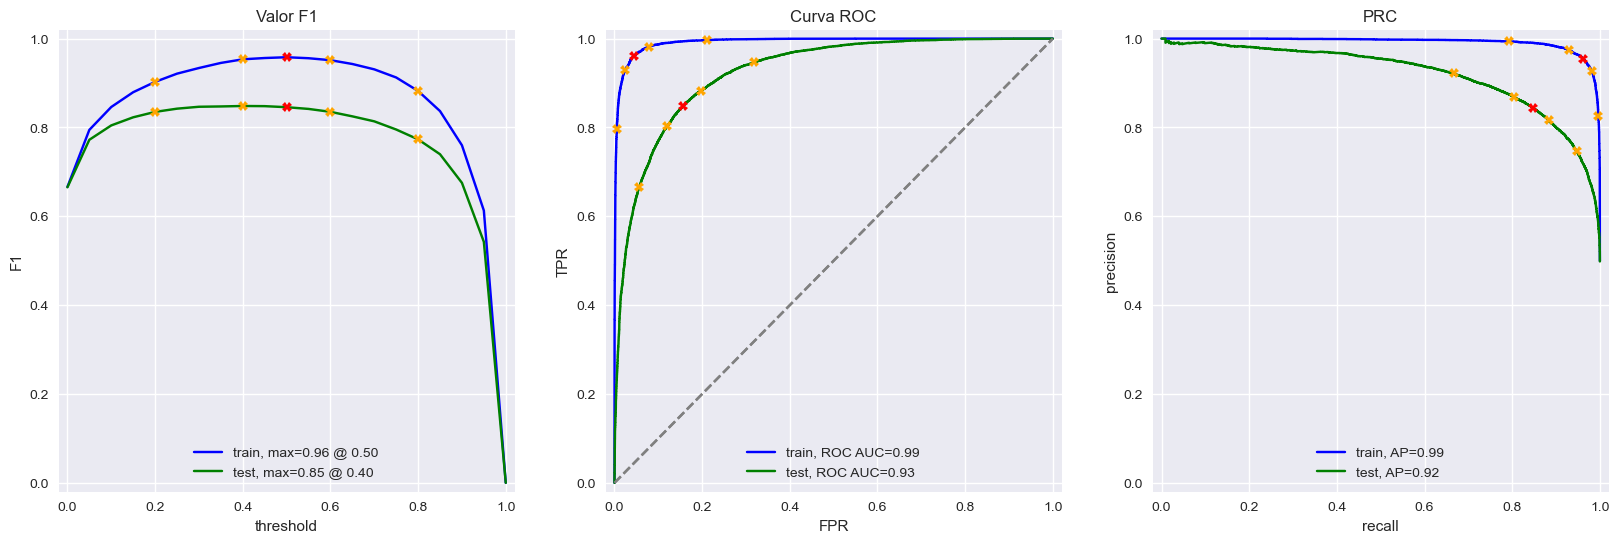

In [41]:
evaluate_model(lgbm, feat_train2, train_target, feat_test2, test_target)

El valor F1 en el conjunto de entrenamiento es 0.96 mientras que en el conjunto de prueba es 0.85. Este último coincide con el objetivo pero es menor que los obtenidos utilizando los modelos anteriores.

[Volver a Contenidos](#back)

### 3. 5. Conclusiones <a id='data_model_conclusions'></a>

En esta etapa se entrenaron 4 modelos, el primero fue el modelo constante (el cual se utilizó como prueba de cordura). De los otros tres modelos, dos de ellos fueron basados en la regresión logística, la diferencia radicó en la librería utilizada para la lematización y tokenización (NLTK y spaCy). Para el último modelo se utilizó LGBMClassifier.

Salvo el modelo constante, todos registraron un valor F1 mayor o igual que el objetivo de 0.85. El que obtuvo el valor F1 mayor (0.88) fue el primer modelo basado en la regresión logística y utilizando la librería NLTK.

[Volver a Contenidos](#back)

## Etapa 4. Ejemplo utilizando los modelos <a id='data_example'></a>

En esta etapa se tomará un ejemplo de reseñas para aplicar los modelos entrenados en la etapa anterior.

In [42]:
# Ejemplo

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Normalización
my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


Se observa que las reseñas positivas están las filas 2, 4, 5, 7, mientras que las negativas están en las filas 0, 1, 3, 6.

Se aplicarán los modelos entrenados para clasificar las reseñas.

**Modelo 1 - NLTK, TF-IDF, LR**

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr.predict_proba(count_tf_idf2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.28:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.20:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.42:  i didn t expect the reboot to be so good writers really cared about the source material
0.46:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Las probabilidades de las filas 4 y 5 (contando desde 0) son menores a 0.5 cuando en realidad son positivas.

**Modelo 2 - spaCy, TF-IDF, LR**

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr2.predict_proba(count_tf_idf.transform(texts.apply(lambda x: lemmatize(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.15:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.20:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.38:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.85:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Nuevamente, los probabilidades de las filas 4 y 5 son menores que 0.5 (incluso menores que con el modelo anterior) cuando en realidad estas filas son positivas.

**Modelo 3 - spaCy, TF-IDF, LGBMClassifier**

In [45]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lgbm.predict_proba(count_tf_idf.transform(texts.apply(lambda x: lemmatize(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.40:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.38:  i didn t expect the reboot to be so good writers really cared about the source material
0.41:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Las probabilidades de las filas 4 y 5 son menores que 0.5 nuevamente. De manera que el primer modelo es el que refleja mejores probabilidades.

[Volver a Contenidos](#back)

## Etapa 5. Conclusión general <a id='data_conclusion'></a>

En la primera etapa se preprocesaron los datos, en primer se eliminaron dos filas con valores ausentes (los únicos en el dataframe). No se encontraron filas duplicadas.

En la segunda etapa se analizaron lo datos, donde se obersvó que la producción de este tipo de películas tuvo en crecimiento constante hasta el año 2006, posterior a ese año decreció hasta casi desaparecer. También se observó que la mayor cantidad de reseñas por película es 30, aunque la mayoría de películas sólo cuenta con una reseña. Además, cada año se tienen más reseñas negativas que positivas, sin embargo, como conjunto están balanceadas.

En la tercera etapa se entrenaron 4 modelos, el primero de ellos fue constante y se tomó como base para prueba de cordura. De los otros tres modelos, dos de ellos se basaron en la regresión logística y para el tercero se utilizó LGBMClassifier. Estos últimos tres tuvieron un valor F1 mayor o igual que 0.85 en las predicciones con el conjunto de prueba. El mejor de ellos fue el modelo 1 basado en la regresión logística y utilizando la librería NLTK.

Finalmente, en la etapa 4, se utilizó un ejemplo con 8 reseñas en las que se aplicaron los tres modelos entrenados. La mejor clasificación fue la obtenida con el modelo 1. Por esta razón se concluye que es el que tienen mejor calidad.

[Volver a Contenidos](#back)